<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/MultiframeImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation of moving objects from exposure sequences
## David Brady
## University of Arizona
## May 2025

We consider estimation of an image $f$ from a sequence of exposures. To compensate for object motion between exposures, we transform the sequence into a set of coded planes, which are then processed by a neural estimator to recover the original object. Encoding and decoding is necessary because the data processing system lacks the capacity to estimate the scene from the full original sequence.

## libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output
import ipywidgets as widgets


## Object motion model

As example objects we use the MNIST digits. Each digit is randomly placed in a N by N pixel grid and moves linearly in a random direction over F frames.

In [119]:

# Re-including the generate_noisy_digit_motion function for a self-contained applet
def generate_noisy_digit_motion(
    digit_image=None,
    frame_size=(96, 96),
    num_frames=40,
    noise_scale_factor=1
):
    """
    Generates a sequence of frames showing an MNIST-like digit moving with
    Poisson noise.

    Args:
        digit_image (np.ndarray, optional): A 2D numpy array representing the
            digit (e.g., 28x28). Pixel values should be between 0 and 1.
            If None, a placeholder square digit will be used.
        frame_size (tuple): The (height, width) of the output frames.
        num_frames (int): The number of frames in the sequence.
        noise_scale_factor (float): A factor to scale pixel intensities before
            applying Poisson noise. Higher values result in less apparent noise.
            This effectively sets the mean of the Poisson distribution for
            each pixel.

    Returns:
        np.ndarray: A 3D numpy array of shape (num_frames, frame_height, frame_width)
            containing the sequence of noisy frames. Pixel values are between 0 and 1.
        and a 2D numpy array describing the start position of the digit.
    """
    frame_height, frame_width = frame_size

    # --- Digit Initialization ---
    if digit_image is None:
        digit_height, digit_width = 28, 28
        digit_image = np.zeros((digit_height, digit_width), dtype=np.float32)
        digit_image[5:23, 5:23] = 1.0 # Placeholder white square
    else:
        digit_height, digit_width = digit_image.shape
        digit_image = digit_image.astype(np.float32)
        if digit_image.max() > 1.0:
            digit_image /= digit_image.max()

    if digit_width > frame_width or digit_height > frame_height:
        raise ValueError(
            f"Digit dimensions ({digit_width}x{digit_height}) are larger than "
            f"frame dimensions ({frame_width}x{frame_height})."
        )
    initialPositions=np.zeros((num_frames,2),dtype=np.int8)

    # --- Initial Position Calculation ---
    # keep it in the middle
    max_start_x = frame_width/2
    max_start_y = frame_height/2

    start_x = np.random.randint(frame_width/4, max_start_x + 1)
    start_y = np.random.randint(frame_width/4, max_start_y + 1)
    initialPositions[0,0]=start_x
    initialPositions[0,1]=start_y

    current_x = float(start_x)
    current_y = float(start_y)

    # --- Velocity Calculation ---
    velocity_magnitude = np.random.uniform(0, .5)
    velocity_angle = np.random.uniform(0, 2 * np.pi)

    vx = velocity_magnitude * np.cos(velocity_angle)
    vy = velocity_magnitude * np.sin(velocity_angle)

    # --- Frame Generation Loop ---
    frames = np.zeros((num_frames, frame_height, frame_width), dtype=np.float32)

    for i in range(num_frames):
        frame = np.zeros(frame_size, dtype=np.float32)

        digit_pos_x = int(round(current_x))
        digit_pos_y = int(round(current_y))

        clip_x_start = max(0, digit_pos_x)
        clip_y_start = max(0, digit_pos_y)
        clip_x_end = min(frame_width, digit_pos_x + digit_width)
        clip_y_end = min(frame_height, digit_pos_y + digit_height)

        digit_clip_x_start = max(0, -digit_pos_x)
        digit_clip_y_start = max(0, -digit_pos_y)
        digit_clip_x_end = digit_width - max(0, (digit_pos_x + digit_width) - frame_width)
        digit_clip_y_end = digit_height - max(0, (digit_pos_y + digit_height) - frame_height)

        if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
            digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
            frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
                digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

        # --- Add Poisson Noise ---
        noisy_frame = np.random.poisson(frame * noise_scale_factor) / noise_scale_factor
        noisy_frame = np.clip(noisy_frame, 0.0, 1.0)

        frames[i] = noisy_frame

        # --- Update Position for Next Frame ---
        current_x += vx
        current_y += vy

    return frames, initialPositions


def create_digit_motion_applet(frames=None):
    """
    Creates an interactive display for a sequence of noisy digit motion frames
    suitable for a Jupyter/Colab notebook environment.

    Args:
        digit_image (np.ndarray, optional): A 2D numpy array representing the
            digit (e.g., 28x28). If None, a placeholder square digit will be used.
    """
    # Generate the frames using the previously defined function
    if frames is None:
      frames = generate_noisy_digit_motion()[0]
    num_frames = frames.shape[0]

    # Set up the plot for inline display
    fig, ax = plt.subplots(figsize=(8, 8))
    # Display the initial frame
    image_display = ax.imshow(frames[0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Frame 1 / {num_frames}")
    ax.axis('off') # Hide axes ticks and labels
    plt.close(fig) # Prevent matplotlib from displaying the figure immediately

    # Create the ipywidgets slider
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=num_frames - 1,
        step=1,
        description='Frame:',
        continuous_update=True, # Update as slider is dragged
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    # Create an output widget to hold the plot
    output = widgets.Output()

    # Define the update function for the slider
    def update_plot(change):
        with output:
            clear_output(wait=True) # Clear previous plot
            frame_idx = change['new'] # Get the new value from the slider change event
            image_display.set_data(frames[frame_idx]) # Update the image data
            ax.set_title(f"Frame {frame_idx + 1} / {num_frames}") # Update the title
            display(fig) # Display the updated figure

    # Register the update function to be called when the slider value changes
    frame_slider.observe(update_plot, names='value')

    # Initial display of the plot
    with output:
        display(fig)

    # Display the slider and the output plot together in a VBox
    display(widgets.VBox([frame_slider, output]))



In [120]:
simulated_mnist_digit = np.zeros((28, 28), dtype=np.float32)
simulated_mnist_digit[5:8, 5:23] = 1.0
simulated_mnist_digit[5:23, 20:23] = 1.0
simulated_mnist_digit[20:23, 5:23] = 0.5
create_digit_motion_applet(generate_noisy_digit_motion(simulated_mnist_digit)[0])

## Encoding strategy

This code simulates a compressive projection process for video data, where each frame is encoded onto two data planes using a shifting binary (1/-1) pattern.

The primary goal of this script is to demonstrate how a video, consisting of multiple frames, can be "compressed" into two static data planes. Each pixel from a video frame contributes to one of the two data planes based on a corresponding value in a dynamically shifting code pattern.

How it Works
* Video and Code Initialization:

  * The script takes a 3D NumPy array as video_data (frames, height, width) and a 2D NumPy array as initial_code (height, width).
  *  The initial_code is a pattern of 1s and -1s.

* Frame-by-Frame Processing:

  * The code iterates through each frame of the input video.
  * For each frame, it applies the current_code pattern.
  * If a pixel in the current_code is 1, the corresponding pixel from the video frame is added to data_plane_1.
  * If a pixel in the current_code is -1, the corresponding pixel from the video frame is added to data_plane_2.

* Cyclic Code Shifting:

  * After processing each frame, the current_code is shifted horizontally by one pixel to the right.
  * This shift is cyclic, meaning pixels shifted off the right edge reappear on the left edge. This ensures the 64x64 code pattern is always present and wraps around. The rule code(x,y, t+1) = code(x-1,y,t) is implemented using np.roll(current_code, shift=1, axis=1).

* Output:

  * The function returns the two accumulated data planes (data_plane_1 and data_plane_2).
.

In [62]:

def generate_coded_data_planes(video_data, initial_code):
    """
    Generates two data planes by applying a shifting coded pattern
    to each frame of a video.

    Args:
        video_data (np.ndarray): A 3D NumPy array representing the video.
                                 Shape: (num_frames, height, width).
                                 Each frame is a 64x64 image.
        initial_code (np.ndarray): A 2D NumPy array representing the initial
                                   64x64 coded pattern with values 1 and -1.

    Returns:
        tuple: A tuple containing two 2D NumPy arrays:
               - data_plane_1 (np.ndarray): Accumulated pixel values where code was 1.
               - data_plane_2 (np.ndarray): Accumulated pixel values where code was -1.
    """
    num_frames, height, width = video_data.shape

    # Ensure the initial code matches the frame dimensions
    if initial_code.shape != (height, width):
        raise ValueError(f"Initial code shape must be {height}x{width}, but got {initial_code.shape}")
    if not np.all(np.isin(initial_code, [1, -1])):
        raise ValueError("Initial code must only contain values 1 and -1.")

    # Initialize the two 64x64 data planes with zeros
    data_plane_1 = np.zeros((height, width), dtype=float)
    data_plane_2 = np.zeros((height, width), dtype=float)

    # Make a copy of the initial code to shift it across frames
    current_code = np.copy(initial_code)

    print(f"Processing {num_frames} frames...")

    for t in range(num_frames):
        # Get the current frame
        frame = video_data[t, :, :]

        # Create masks for where the code is 1 and -1
        mask_code_1 = (current_code == 1)
        mask_code_neg_1 = (current_code == -1)

        # Add image pixels to the corresponding data planes
        # Where code is 1, add pixel to data_plane_1
        data_plane_1[mask_code_1] += frame[mask_code_1]
        # Where code is -1, add pixel to data_plane_2
        data_plane_2[mask_code_neg_1] += frame[mask_code_neg_1]

        # Shift the code cyclically by one pixel in the horizontal axis for the next frame
        # code(x,y, t+1) = code(x-1,y,t)
        # This means shifting columns to the right by 1, with wrap-around.
        # np.roll(array, shift, axis)
        # A positive shift means elements are shifted to the right (or down).
        # So, to get code(x-1) into code(x), we need to shift by +1.
        current_code = np.roll(current_code, shift=1, axis=1)

        # Optional: Print progress
        if (t + 1) % 5 == 0 or t == num_frames - 1:
            print(f"  Processed frame {t + 1}/{num_frames}")

    return data_plane_1, data_plane_2





In [63]:
video_data = generate_noisy_digit_motion()[0]
height, width = 96, 96
# 3. Generate an initial 64x64 code with values 1 and -1
# We'll randomly assign 1 or -1 to each position.
initial_code = np.random.choice([1, -1], size=(height, width))
print(f"Generated initial code with shape: {initial_code.shape}")

# 4. Generate the coded data planes
try:
    dp1, dp2 = generate_coded_data_planes(video_data, initial_code)

    print("\n--- Results ---")
    print(f"Shape of Data Plane 1: {dp1.shape}")
    print(f"Shape of Data Plane 2: {dp2.shape}")

    # Optional: Print a small part of the data planes to verify
    # print("\nFirst 5x5 block of Data Plane 1:")
    # print(dp1[:5, :5])
    # print("\nFirst 5x5 block of Data Plane 2:")
    # print(dp2[:5, :5])

except ValueError as e:
    print(f"Error: {e}")



Generated initial code with shape: (96, 96)
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40

--- Results ---
Shape of Data Plane 1: (96, 96)
Shape of Data Plane 2: (96, 96)


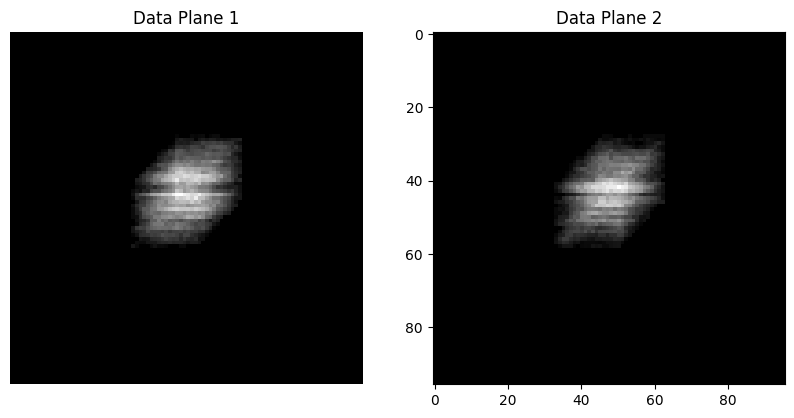

In [64]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dp1, cmap='gray')
plt.title('Data Plane 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dp2, cmap='gray')
plt.title('Data Plane 2')
plt.show()

## Code

As an example code, we use an 8 by 8 random matrix, tiled in an 8 by 8 grid to produce a 64 by 64 element grid

<ipython-input-8-6130ae9971d7>:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  baseCode=np.random.random_integers(0,1,size=(8,8 ))


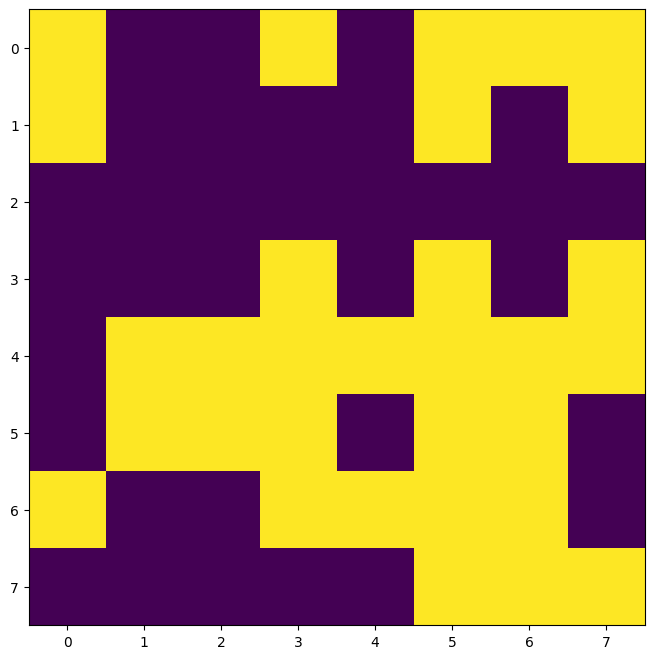

In [8]:
baseCode=np.random.random_integers(0,1,size=(8,8 ))
baseCode=baseCode*2-1
plt.figure(figsize=(8, 8))
plt.imshow(baseCode)

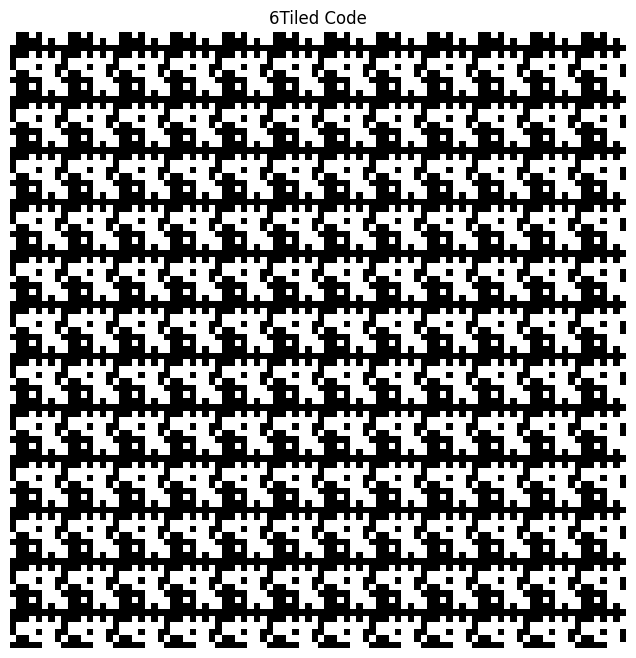

Using tiled code with shape: (96, 96) as initial_code.
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40

--- Results ---
Shape of Data Plane 1: (96, 96)
Shape of Data Plane 2: (96, 96)


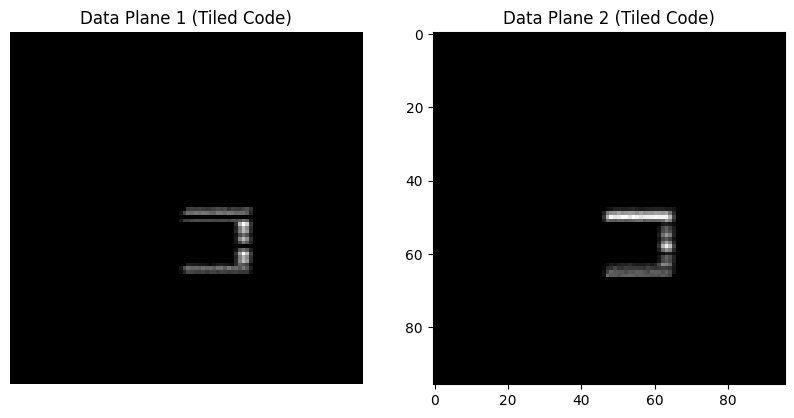

In [65]:

# Create the tiled array
tiled_code = np.tile(baseCode, (12, 12))

# Display the tiled code
plt.figure(figsize=(8, 8))
plt.imshow(tiled_code, cmap='gray', vmin=-1, vmax=1)
plt.title('6Tiled Code')
plt.axis('off')
plt.show()

# Use the tiled code as the initial code for generating data planes
initial_code = tiled_code
print(f"Using tiled code with shape: {initial_code.shape} as initial_code.")


simulated_mnist_digit = np.zeros((28, 28), dtype=np.float32)
simulated_mnist_digit[5:8, 5:23] = 1.0
simulated_mnist_digit[5:23, 20:23] = 1.0
simulated_mnist_digit[20:23, 5:23] = 0.5
video_data = generate_noisy_digit_motion(simulated_mnist_digit)[0]


# 4. Generate the coded data planes using the tiled code
try:
    dp1, dp2 = generate_coded_data_planes(video_data, initial_code)

    print("\n--- Results ---")
    print(f"Shape of Data Plane 1: {dp1.shape}")
    print(f"Shape of Data Plane 2: {dp2.shape}")

    # Display the resulting data planes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(dp1, cmap='gray')
    plt.title('Data Plane 1 (Tiled Code)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dp2, cmap='gray')
    plt.title('Data Plane 2 (Tiled Code)')
    plt.show()

except ValueError as e:
    print(f"Error: {e}")
except NameError:
    print("Error: 'video_data' is not defined. Please run the cell that generates video_data first.")


## Create training data

Streaming output truncated to the last 5000 lines.
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame

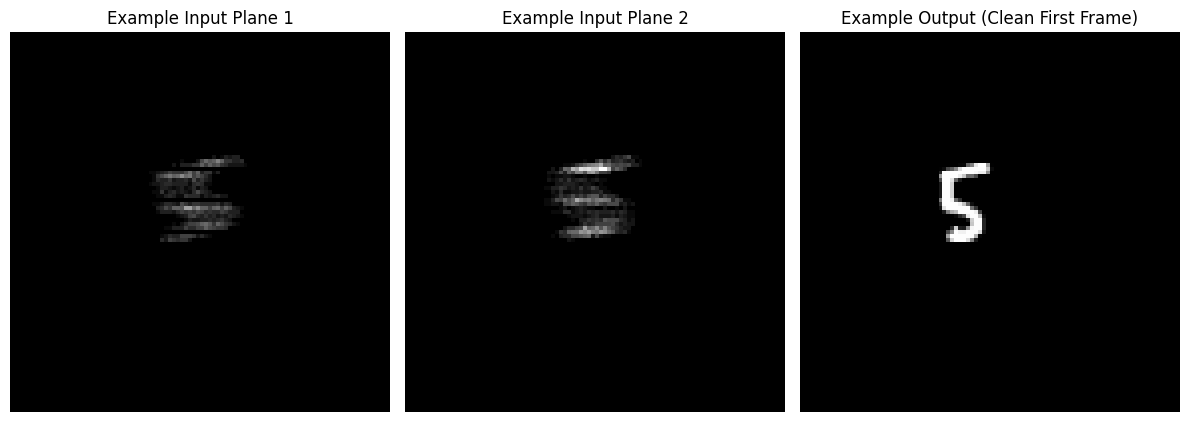

In [121]:
# prompt: load the MNIST data set of handdrawn digits. Use a randomly selected set of 2500 digits to generate training input output pairs with inputs consisting of the encoded frames from a video stack created from generate_noisy_digit_motion(mnist_digit) and the output consisting of the first frame of the video stack with the corresponding digit uncorrupted by noise. generate_noisy_digit_motion(mnist_digit) [0] contains the video stack and generate_noisy_digit_motion(mnist_digit)[1] contains the start position for the digit, which can be used to generate the uncorrupted first frame. normalize the inputs to lie between 0 and 1

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
import tensorflow as tf

# Load the MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Select a random set of 2500 digits
num_samples = 2500
random_indices = np.random.choice(len(mnist_train_images), num_samples, replace=False)
selected_digits = mnist_train_images[random_indices]

# Initialize lists to store training data
X_train = []
y_train = []

print(f"Generating {num_samples} training examples...")

# Generate training input-output pairs
for i, digit_image in enumerate(selected_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40)

    # Generate the encoded input (coded frames)
    # We need an initial code. Let's reuse the tiled code or generate a new random one.
    # Using the tiled code from the previous section if it exists, otherwise generate a random one
    if 'tiled_code' in locals():
        initial_code = tiled_code
    else:
        initial_code = np.random.choice([1, -1], size=(96, 96))


    dp1, dp2 = generate_coded_data_planes(video_stack, initial_code)
    # Concatenate the two data planes to form the input features
    # Shape will be (height, width, 2)
    encoded_input = np.stack([dp1, dp2], axis=-1)

    # Normalize the encoded input to be between 0 and 1
    # Find min and max values across both planes for normalization
    min_val = np.min(encoded_input)
    max_val = np.max(encoded_input)
    if max_val - min_val > 1e-6: # Avoid division by zero or near-zero
      normalized_encoded_input = (encoded_input - min_val) / (max_val - min_val)
    else:
      normalized_encoded_input = np.zeros_like(encoded_input) # Handle case where all values are the same


    # Generate the output (uncorrupted first frame)
    # The uncorrupted first frame can be reconstructed using the original digit image
    # and the start position [0] from generate_noisy_digit_motion.
    # This is slightly different from the request, which asked for the first frame
    # *with* the corresponding digit uncorrupted by noise. The first frame in
    # video_stack already has noise. Let's reconstruct the clean digit image
    # within the frame size at the specified start position.

    clean_first_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    # Place the clean digit image into the clean frame at the start position
    # Handle clipping if the digit goes out of bounds
    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_first_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]


    X_train.append(normalized_encoded_input)
    y_train.append(clean_first_frame)

    if (i + 1) % 100 == 0 or i == num_samples - 1:
        print(f"  Generated {i + 1}/{num_samples} samples")

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Add a channel dimension to y_train if needed for model compatibility (e.g., CNNs expect channel)
# Assuming grayscale output, add a channel dimension of 1
y_train = np.expand_dims(y_train, axis=-1)


print("\nTraining data shapes:")
print("Input (X_train):", X_train.shape) # Should be (num_samples, height, width, 2)
print("Output (y_train):", y_train.shape) # Should be (num_samples, height, width, 1)

# Display an example training pair
example_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_train[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Input Plane 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X_train[example_idx, :, :, 1], cmap='gray', vmin=0, vmax=1)
plt.title('Example Input Plane 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_train[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Output (Clean First Frame)')
plt.axis('off')

plt.tight_layout()
plt.show()

Streaming output truncated to the last 5000 lines.
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame

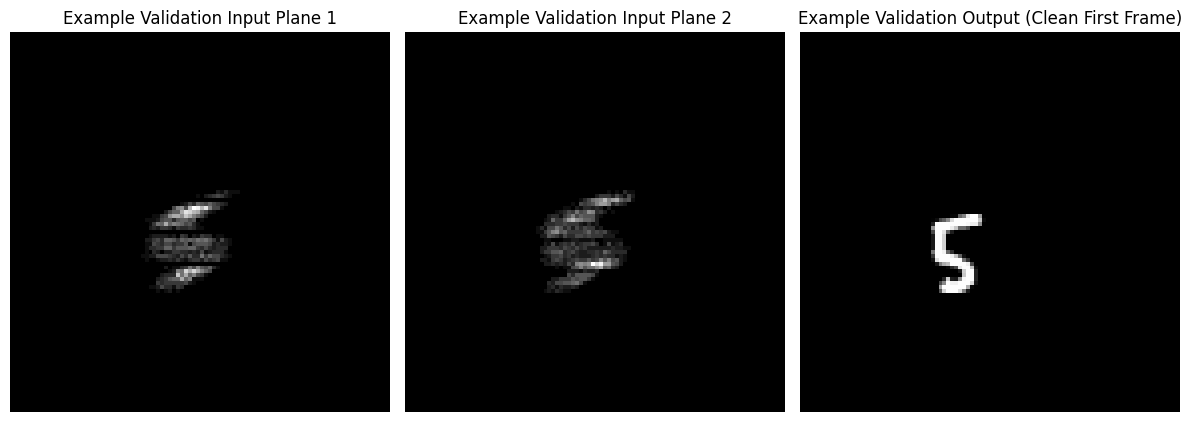

In [122]:
# prompt: using the code from above generate 500 test and validation input output sets. normalize the inputs to lie between 0 and 1


# Initialize lists to store validation data
X_val = []
y_val = []

print(f"\nGenerating {num_samples} validation examples...")

# Generate validation input-output pairs
# Reuse the same selected_digits for consistency, but generate new motion/noise
for i, digit_image in enumerate(selected_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40)

    # Generate the encoded input (coded frames)
    # Use the same initial code for consistency
    if 'tiled_code' in locals():
        initial_code = tiled_code
    else:
        initial_code = np.random.choice([1, -1], size=(96, 96))

    dp1, dp2 = generate_coded_data_planes(video_stack, initial_code)
    # Concatenate the two data planes to form the input features
    # Shape will be (height, width, 2)
    encoded_input = np.stack([dp1, dp2], axis=-1)

    # Normalize the encoded input to be between 0 and 1
    min_val = np.min(encoded_input)
    max_val = np.max(encoded_input)
    if max_val - min_val > 1e-6:
      normalized_encoded_input = (encoded_input - min_val) / (max_val - min_val)
    else:
      normalized_encoded_input = np.zeros_like(encoded_input)


    # Generate the output (uncorrupted first frame)
    clean_first_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_first_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]


    X_val.append(normalized_encoded_input)
    y_val.append(clean_first_frame)

    if (i + 1) % 100 == 0 or i == num_samples - 1:
        print(f"  Generated {i + 1}/{num_samples} samples")

# Convert lists to numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

# Add a channel dimension to y_val
y_val = np.expand_dims(y_val, axis=-1)


print("\nValidation data shapes:")
print("Input (X_val):", X_val.shape) # Should be (num_samples, height, width, 2)
print("Output (y_val):", y_val.shape) # Should be (num_samples, height, width, 1)

# Display an example validation pair
example_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_val[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Input Plane 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X_val[example_idx, :, :, 1], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Input Plane 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_val[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Output (Clean First Frame)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Neural estimator

In [123]:
# prompt:  create a 4 layer unet with skip connections to associate the input planes to the output planes with gelu activation functions for the hidden layers and linear activation for the final layer with MSE loss. Use 4 filters in the first layer, 8 in the second layer, 16 in the third, 32 in the fourth and then 32 16, 8 4 in the decoder

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu

def unet_model(input_shape=(96, 96, 2)):
    inputs = Input(input_shape)

    # Encoder (Downsampling path)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(inputs)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(pool1)
    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(pool2)
    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool3)
    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck layer
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool4)
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv5)

    # Decoder (Upsampling path with skip connections)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(up6)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(up7)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(up8)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(up9)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv9)

    # Output layer (Linear activation for reconstruction)
    outputs = Conv2D(1, (1, 1), activation='linear')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='mse')

    return model

# Create the model
model = unet_model()
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 96, 96, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 96, 96, 4) │         76 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 96, 96, 4) │        148 │ conv2d_127[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 48, 48, 4) │          0 │ conv2d_128[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 48, 48, 8) │        296 │ max_pooling2d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 48, 48, 8) │        584 │ conv2d_129[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 24, 24, 8) │          0 │ conv2d_130[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 24, 24,    │      1,168 │ max_pooling2d_28… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 24, 24,    │      2,320 │ conv2d_131[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 12, 12,    │          0 │ conv2d_132[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 12, 12,    │      4,640 │ max_pooling2d_29… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 12, 12,    │      9,248 │ conv2d_133[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 6, 6, 32)  │          0 │ conv2d_134[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 6, 6, 32)  │      9,248 │ max_pooling2d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 6, 6, 32)  │      9,248 │ conv2d_135[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_27    │ (None, 12, 12,    │          0 │ conv2d_136[0][0]  │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 12, 12,    │          0 │ up_sampling2d_27… │
│ (Concatenate)       │ 64)               │            │ conv2d_134[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 12, 12,    │     18,464 │ concatenate_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 12, 12,    │      9,248 │ conv2d_137[0][0]

 Total params: 76,845 (300.18 KB)

 Trainable params: 76,845 (300.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/s

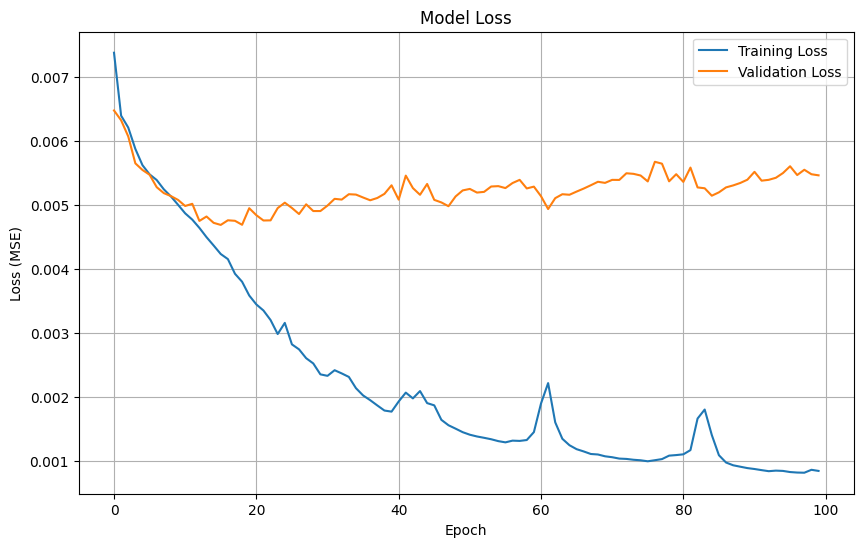

In [124]:
# prompt: train the network with the training and validation data sets from above

import matplotlib.pyplot as plt
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Or a number of epochs suitable for your data size
    batch_size=32  # Or a batch size that fits your memory
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


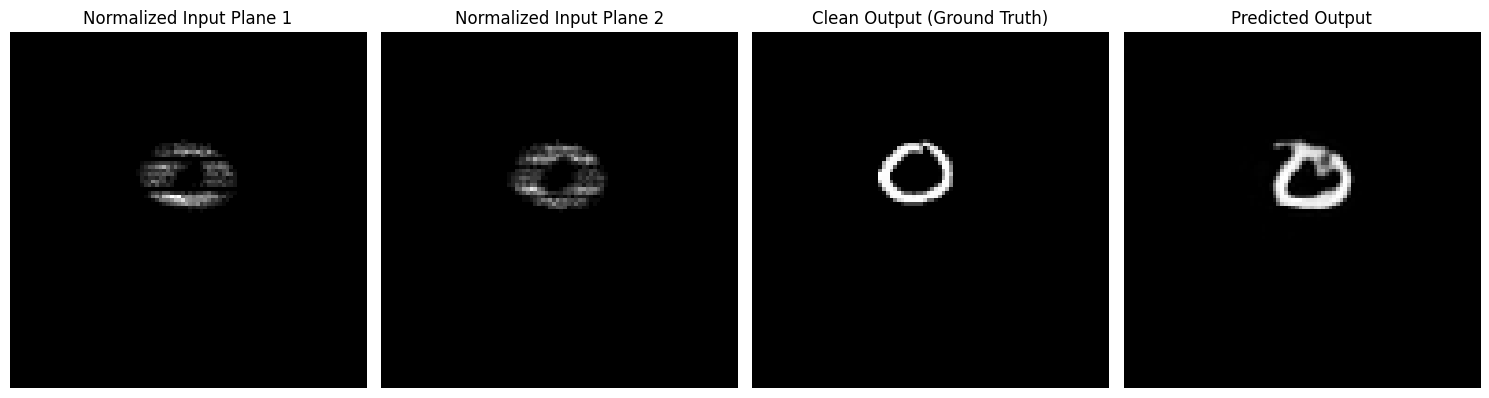

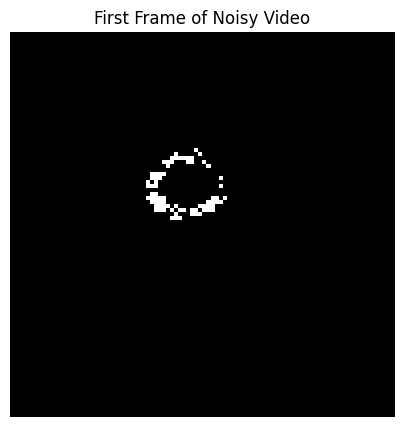

In [129]:
# prompt: choosing a random digit from the test data set, generate a noisy video, then generate a normalized input and output pair, predict the output from the input. show the input and output pair, the output predicted by the network and the first frame of the noisy video

import matplotlib.pyplot as plt
import numpy as np
# Choosing a random digit from the test data set
random_test_idx = np.random.randint(0, len(mnist_test_images))
test_digit_image_clean = mnist_test_images[random_test_idx].astype(np.float32) / 255.0

# Generate a noisy video with this digit
noisy_video_stack, test_start_pos = generate_noisy_digit_motion(
    digit_image=test_digit_image_clean,
    frame_size=(96, 96),
    num_frames=40,
    noise_scale_factor=1 # You can adjust noise here
)

# Generate the normalized input pair from the noisy video
# Use the same initial code as used for training data
if 'tiled_code' in locals():
    initial_code_test = tiled_code
else:
    # Fallback: generate a random one if tiled_code wasn't created
    initial_code_test = np.random.choice([1, -1], size=(96, 96))

test_dp1, test_dp2 = generate_coded_data_planes(noisy_video_stack, initial_code_test)
encoded_input_test = np.stack([test_dp1, test_dp2], axis=-1)

# Normalize the input using the min/max from the training data (or you could use global min/max from test)
# For demonstration, let's assume the training data normalization range is representative.
# Ideally, you'd save and reuse the training normalization parameters.
# As a simple approach here, we'll normalize based on the test input's min/max.
min_val_test = np.min(encoded_input_test)
max_val_test = np.max(encoded_input_test)
if max_val_test - min_val_test > 1e-6:
  normalized_encoded_input_test = (encoded_input_test - min_val_test) / (max_val_test - min_val_test)
else:
  normalized_encoded_input_test = np.zeros_like(encoded_input_test)

# Reshape for model prediction (add batch dimension)
normalized_encoded_input_test = np.expand_dims(normalized_encoded_input_test, axis=0)


# Generate the corresponding clean output (uncorrupted first frame)
clean_output_test = np.zeros((96, 96), dtype=np.float32)
test_start_x = test_start_pos[0, 0]
test_start_y = test_start_pos[0, 1]
digit_h, digit_w = test_digit_image_clean.shape

clip_x_start = max(0, test_start_x)
clip_y_start = max(0, test_start_y)
clip_x_end = min(96, test_start_x + digit_w)
clip_y_end = min(96, test_start_y + digit_h)

digit_clip_x_start = max(0, -test_start_x)
digit_clip_y_start = max(0, -test_start_y)
digit_clip_x_end = digit_w - max(0, (test_start_x + digit_w) - 96)
digit_clip_y_end = digit_h - max(0, (test_start_y + digit_h) - 96)

if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
    digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
    clean_output_test[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
        test_digit_image_clean[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

# Reshape for display if needed (remove channel dimension if present)
if clean_output_test.ndim == 3 and clean_output_test.shape[-1] == 1:
    clean_output_test = clean_output_test[:, :, 0]


# Predict the output from the input
predicted_output = model.predict(normalized_encoded_input_test)

# The prediction is a batch of size 1, so take the first (and only) element
predicted_output_image = predicted_output[0, :, :, 0] # Remove batch and channel dimensions


# Show the input and output pair, the predicted output, and the first frame of the noisy video
plt.figure(figsize=(15, 5))

# Display Input Plane 1
plt.subplot(1, 4, 1)
plt.imshow(normalized_encoded_input_test[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Normalized Input Plane 1')
plt.axis('off')

# Display Input Plane 2
plt.subplot(1, 4, 2)
plt.imshow(normalized_encoded_input_test[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
plt.title('Normalized Input Plane 2')
plt.axis('off')

# Display Clean Output (Ground Truth)
plt.subplot(1, 4, 3)
plt.imshow(clean_output_test, cmap='gray', vmin=0, vmax=1)
plt.title('Clean Output (Ground Truth)')
plt.axis('off')

# Display Predicted Output
plt.subplot(1, 4, 4)
plt.imshow(predicted_output_image, cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Output')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display the first frame of the noisy video
plt.figure(figsize=(5, 5))
plt.imshow(noisy_video_stack[0], cmap='gray', vmin=0, vmax=1)
plt.title('First Frame of Noisy Video')
plt.axis('off')
plt.show()


In [77]:
np.max(training_data[0][1])

np.float32(1.0)